# Project 2 - Movie Genre Classification
## Classify a movie genre based on its plot.
Hazel Vanesa Jaime Huerfano - Sandra Yessell Tellez Moreno

## Contenido

- **Intro** 
Exploración visual de los datos
- **Preprocesamiento**
Veremos varias tecnicas de limpieza y homogenización
- **Modelos**
- **API**

## Intro

### Librerías

In [89]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
import itertools
import re, string
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
import string
from scipy import sparse
import seaborn as sns
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [90]:
dataTesting = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [91]:
dataTesting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3383 entries, 1 to 11275
Data columns (total 3 columns):
year     3383 non-null int64
title    3383 non-null object
plot     3383 non-null object
dtypes: int64(1), object(2)
memory usage: 105.7+ KB


In [92]:
dataTraining = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTraining=dataTraining.sort_index()
dataTraining.head()

,year,title,plot,genres,rating
0,1995,Major Payne,major benson winifred payne is being discharge...,"['Adventure', 'Comedy', 'Family']",6.1
2,2008,Outlander,"in N ad , in the iron age , a spacecraft c...","['Action', 'Adventure', 'Sci-Fi']",6.3
3,2011,Mission: Impossible - Ghost Protocol,"imf agent ethan hunt , who ' s been out for s...","['Action', 'Adventure', 'Thriller']",7.4
8,2001,Mockingbird Don't Sing,"on november N , N on the cbs evening news...","['Biography', 'Drama']",6.5
10,2011,Snow Flower and the Secret Fan,"in N th - century china , seven year old gir...","['Drama', 'History']",6.1


In [93]:
dataTraining.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7895 entries, 0 to 11277
Data columns (total 5 columns):
year      7895 non-null int64
title     7895 non-null object
plot      7895 non-null object
genres    7895 non-null object
rating    7895 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 370.1+ KB


In [0]:
#Eliminamos las comillas simples del texto en la columna generos
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
#Trannsformamos los generos de lista a a una matriz binaria indicando si el genero está (1) en dicha observación o no (0)
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [95]:
y_genres

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [0, 1, 1, ..., 0, 0, 1]])

In [96]:
#Obtenemos los nombre de la matriz y_genres
cols = le.classes_
print(len(cols))
cols

24


array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western'], dtype=object)

In [0]:
#Obtenemos el index del df y lo ponemos en una lista
obs=dataTraining.index.tolist()

In [98]:
#Ponemos en un dataframe los generos, con el fin de poder hacer algunas descriptivas
generos = pd.DataFrame.from_records(y_genres, columns=cols,index=obs)
print("Observaciones",len(generos))

Observaciones 7895


In [0]:
result = pd.concat([generos, dataTraining['year']], axis=1, join_axes=[generos.index])

In [0]:
#Cambiamos la estructura del data frame anterior
generos = pd.DataFrame(generos.sum(axis=0), columns=['cant'])
generos=generos.sort_values(by='cant', ascending=False)

0    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

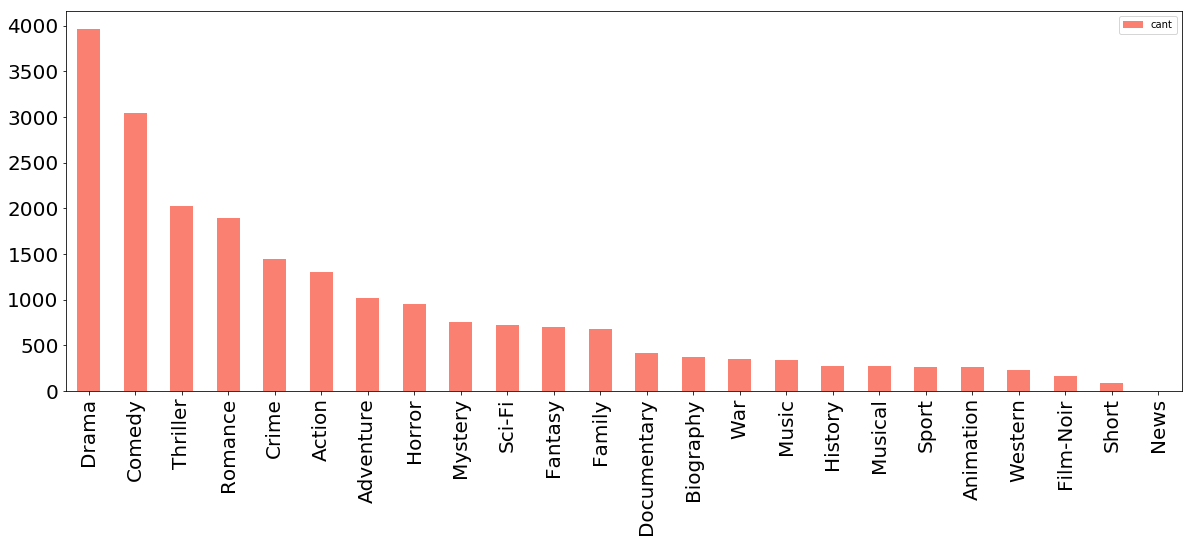

In [101]:
pd.Series(generos.plot(kind = "bar",color='salmon',figsize=(20,7),fontsize=20))

In [0]:
a=(pd.pivot_table(dataTraining,index=["year"],values=["rating"],aggfunc=len)).sort_values(by='rating', ascending=False)
a=a[:40]

0    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

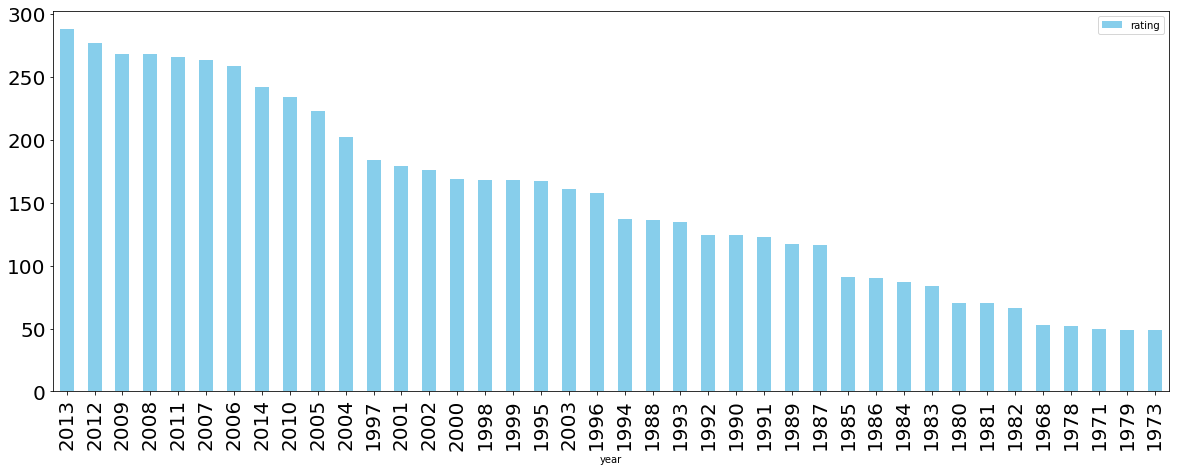

In [103]:
pd.Series((a).plot(kind="bar",color="skyblue",figsize=(20,7),fontsize=20))

## Preprocesamiento

In [0]:
#Unimos el titulo con la descripción
dataTraining['plot'] = dataTraining['title'] + ' ' + dataTraining['plot']

In [0]:
dataTesting['plot'] = dataTesting['title'] + ' ' + dataTesting['plot']

In [106]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [0]:
#Funcion Remover puntuacion
def puntuacion(texto):
    texto1="".join([char for char in texto if char not in string.punctuation])
    return texto1

In [0]:
#Funcion Remover numeros
def numeracion(texto):
    texto1="".join([char for char in texto if not char.isdigit()])
    return texto1

In [0]:
#Contar puntuacion
def cuenta_puntuacion(texto):
    cuenta=sum([1 for char in texto if char in string.punctuation])
    return cuenta

In [0]:
dataTraining['cuenta_p']=dataTraining['plot'].apply(lambda x: cuenta_puntuacion(x))
dataTraining['cuenta_p_title']=dataTraining['title'].apply(lambda x: cuenta_puntuacion(x))
dataTraining['plot']=dataTraining['plot'].apply(lambda x: puntuacion(x))
dataTraining['plot'] = dataTraining['plot'].apply(lambda x: x.replace(" N ", ''))
dataTraining['plot'] = dataTraining['plot'].apply(lambda x: x.lower())
dataTraining['plot']=dataTraining['plot'].apply(lambda x: numeracion(x))
dataTraining['largo']=dataTraining['plot'].apply(lambda x: len(x) - x.count(" "))
dataTraining['largo_t']=dataTraining['title'].apply(lambda x: len(x) - x.count(" "))

In [0]:
dataTesting['cuenta_p']=dataTesting['plot'].apply(lambda x: cuenta_puntuacion(x))
dataTesting['cuenta_p_title']=dataTesting['title'].apply(lambda x: cuenta_puntuacion(x))
dataTesting['plot']=dataTesting['plot'].apply(lambda x: puntuacion(x))
dataTesting['plot'] = dataTesting['plot'].apply(lambda x: x.replace(" N ", ''))
dataTesting['plot'] = dataTesting['plot'].apply(lambda x: x.lower())
dataTesting['plot']=dataTesting['plot'].apply(lambda x: numeracion(x))
dataTesting['largo']=dataTesting['plot'].apply(lambda x: len(x) - x.count(" "))
dataTesting['largo_t']=dataTesting['title'].apply(lambda x: len(x) - x.count(" "))

In [0]:
def tokenize(text):
    tokens=re.split('\W+',text)
    return tokens

In [113]:
plots = dataTraining['plot'].str.cat(sep=' ')
tokens = tokenize(plots)
vocabulary = set(tokens)
print("Corpus",len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)

Corpus 39757


In [0]:
b=pd.DataFrame.from_dict(frequency_dist, orient='index', columns=['Cant'])
b=b.sort_values(by='Cant', ascending=False)
b=b[:30]

0    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

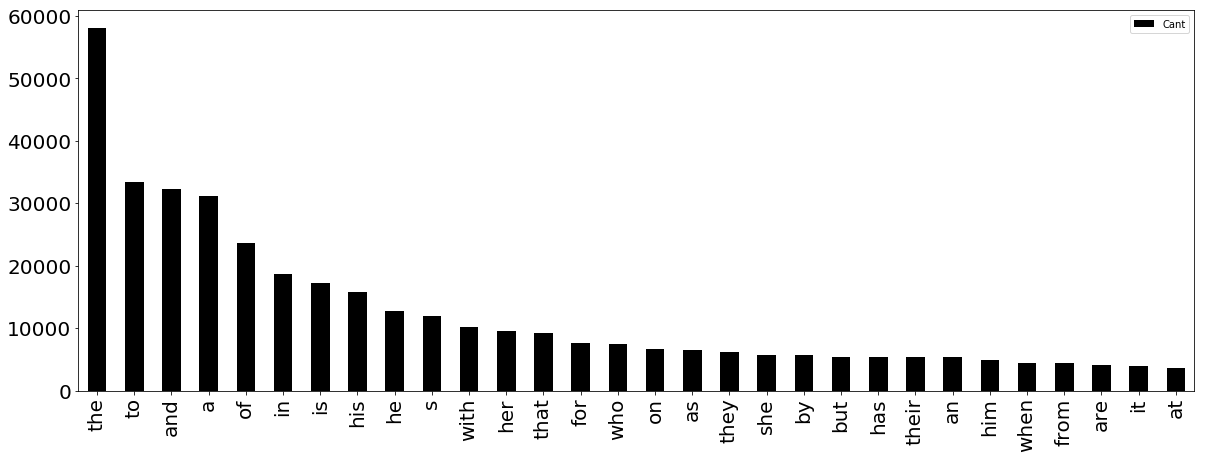

In [115]:
pd.Series((b).plot(kind="bar",color="k",figsize=(20,7),fontsize=20))

In [116]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]
vocabulary = set(tokens)
print("Corpus",len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)

Corpus 39607


In [0]:
c=pd.DataFrame.from_dict(frequency_dist, orient='index', columns=['Cant'])
c=c.sort_values(by='Cant', ascending=False)
c=c[:30]

0    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

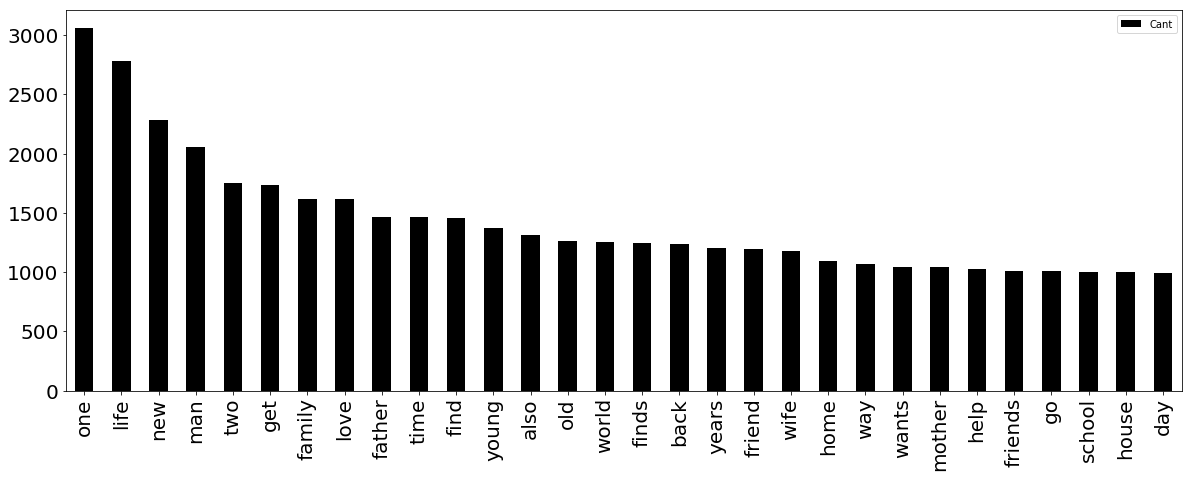

In [118]:
pd.Series((c).plot(kind="bar",color="k",figsize=(20,7),fontsize=20))

In [0]:
stopwords_per=['the','to','s']

In [0]:
dataTraining['plot_tokens']=dataTraining['plot'].apply(lambda x: tokenize(x))

In [0]:
dataTesting['plot_tokens']=dataTesting['plot'].apply(lambda x: tokenize(x))

In [0]:
def remove_stopwords(texto):
    texto1=[word for word in texto if word not in stopwords_per]
    return texto1

In [0]:
dataTesting['plot_tokens_ww']=dataTesting['plot_tokens'].apply(lambda x: remove_stopwords(x))

In [0]:
dataTraining['plot_tokens_ww']=dataTraining['plot_tokens'].apply(lambda x: remove_stopwords(x))

In [0]:
ps = nltk.PorterStemmer()
stemmer = SnowballStemmer('english')
lanca_stemmer = LancasterStemmer()
wnl = nltk.WordNetLemmatizer()

In [0]:
def stemming_snowball(texto):
    texto1=[stemmer.stem(word) for word in texto]
    return texto1

In [0]:
def stemming_lancaster(texto):
    texto1=[lanca_stemmer.stem(word) for word in texto]
    return texto1

In [0]:
def stemming(texto):
    texto1=[ps.stem(word) for word in texto]
    return texto1

In [0]:
def lemmatizing(texto):
    texto1=[wnl.lemmatize(word) for word in texto]
    return texto1

In [0]:
dataTraining['plot_lemming']=dataTraining['plot_tokens_ww'].apply(lambda x: lemmatizing(x))
dataTraining['plot_stemmed']=dataTraining['plot_tokens_ww'].apply(lambda x: stemming(x))
dataTraining['plot_stemmed_snow']=dataTraining['plot_tokens_ww'].apply(lambda x: stemming_snowball(x))
dataTraining['plot_stemmed_lancaster']=dataTraining['plot_tokens_ww'].apply(lambda x: stemming_lancaster(x))

In [131]:
dataTraining.head()

,year,title,plot,genres,rating,cuenta_p,cuenta_p_title,largo,largo_t,plot_tokens,plot_tokens_ww,plot_lemming,plot_stemmed,plot_stemmed_snow,plot_stemmed_lancaster
0,1995,Major Payne,major payne major benson winifred payne is bei...,"[Adventure, Comedy, Family]",6.1,18,0,499,10,"[major, payne, major, benson, winifred, payne,...","[major, payne, major, benson, winifred, payne,...","[major, payne, major, benson, winifred, payne,...","[major, payn, major, benson, winifr, payn, is,...","[major, payn, major, benson, winifr, payn, is,...","[maj, payn, maj, benson, winifr, payn, is, bei..."
2,2008,Outlander,outlander in ad in the iron age a spacecr...,"[Action, Adventure, Sci-Fi]",6.3,15,0,385,9,"[outlander, in, ad, in, the, iron, age, a, spa...","[outlander, in, ad, in, iron, age, a, spacecra...","[outlander, in, ad, in, iron, age, a, spacecra...","[outland, in, ad, in, iron, age, a, spacecraft...","[outland, in, ad, in, iron, age, a, spacecraft...","[outland, in, ad, in, iron, ag, a, spacecraft,..."
3,2011,Mission: Impossible - Ghost Protocol,mission impossible ghost protocol imf agent e...,"[Action, Adventure, Thriller]",7.4,30,2,982,32,"[mission, impossible, ghost, protocol, imf, ag...","[mission, impossible, ghost, protocol, imf, ag...","[mission, impossible, ghost, protocol, imf, ag...","[mission, imposs, ghost, protocol, imf, agent,...","[mission, imposs, ghost, protocol, imf, agent,...","[miss, imposs, ghost, protocol, imf, ag, eth, ..."
8,2001,Mockingbird Don't Sing,mockingbird dont sing on november on the c...,"[Biography, Drama]",6.5,27,1,824,20,"[mockingbird, dont, sing, on, november, on, th...","[mockingbird, dont, sing, on, november, on, cb...","[mockingbird, dont, sing, on, november, on, cb...","[mockingbird, dont, sing, on, novemb, on, cb, ...","[mockingbird, dont, sing, on, novemb, on, cbs,...","[mockingbird, dont, sing, on, novemb, on, cbs,..."
10,2011,Snow Flower and the Secret Fan,snow flower and the secret fan in th century ...,"[Drama, History]",6.1,22,0,625,25,"[snow, flower, and, the, secret, fan, in, th, ...","[snow, flower, and, secret, fan, in, th, centu...","[snow, flower, and, secret, fan, in, th, centu...","[snow, flower, and, secret, fan, in, th, centu...","[snow, flower, and, secret, fan, in, th, centu...","[snow, flow, and, secret, fan, in, th, century..."


In [0]:
dataTesting['plot_lemming']=dataTesting['plot_tokens_ww'].apply(lambda x: lemmatizing(x))
dataTesting['plot_stemmed']=dataTesting['plot_tokens_ww'].apply(lambda x: stemming(x))
dataTesting['plot_stemmed_snow']=dataTesting['plot_tokens_ww'].apply(lambda x: stemming_snowball(x))
dataTesting['plot_stemmed_lancaster']=dataTesting['plot_tokens_ww'].apply(lambda x: stemming_lancaster(x))

In [133]:
dataTesting.head()

,year,title,plot,cuenta_p,cuenta_p_title,largo,largo_t,plot_tokens,plot_tokens_ww,plot_lemming,plot_stemmed,plot_stemmed_snow,plot_stemmed_lancaster
1,1999,Message in a Bottle,message in a bottle who meets by fate shall ...,11,0,366,16,"[message, in, a, bottle, who, meets, by, fate,...","[message, in, a, bottle, who, meets, by, fate,...","[message, in, a, bottle, who, meet, by, fate, ...","[messag, in, a, bottl, who, meet, by, fate, sh...","[messag, in, a, bottl, who, meet, by, fate, sh...","[mess, in, a, bottl, who, meet, by, fat, shal,..."
4,1978,Midnight Express,midnight express the true story of billy hayes...,2,0,118,15,"[midnight, express, the, true, story, of, bill...","[midnight, express, true, story, of, billy, ha...","[midnight, express, true, story, of, billy, ha...","[midnight, express, true, stori, of, billi, ha...","[midnight, express, true, stori, of, billi, ha...","[midnight, express, tru, story, of, bil, hay, ..."
5,1996,Primal Fear,primal fear martin vail left the chicago da s...,48,0,1560,10,"[primal, fear, martin, vail, left, the, chicag...","[primal, fear, martin, vail, left, chicago, da...","[primal, fear, martin, vail, left, chicago, da...","[primal, fear, martin, vail, left, chicago, da...","[primal, fear, martin, vail, left, chicago, da...","[prim, fear, martin, vail, left, chicago, da, ..."
6,1950,Crisis,crisis husband and wife americans dr eugene ...,22,0,880,6,"[crisis, husband, and, wife, americans, dr, eu...","[crisis, husband, and, wife, americans, dr, eu...","[crisis, husband, and, wife, american, dr, eug...","[crisi, husband, and, wife, american, dr, euge...","[crisi, husband, and, wife, american, dr, euge...","[cris, husband, and, wif, am, dr, eug, and, mr..."
7,1959,The Tingler,the tingler the coroner and scientist dr war...,29,0,831,10,"[the, tingler, the, coroner, and, scientist, d...","[tingler, coroner, and, scientist, dr, warren,...","[tingler, coroner, and, scientist, dr, warren,...","[tingler, coron, and, scientist, dr, warren, c...","[tingler, coron, and, scientist, dr, warren, c...","[tingl, coron, and, sci, dr, war, chapin, is, ..."


In [0]:
def texto(texto):
    texto1=" ".join(texto)
    return texto1

In [0]:
dataTraining['plot1']=dataTraining['plot_tokens_ww'].apply(lambda x: texto(x))
dataTraining['plot_lemming']=dataTraining['plot_lemming'].apply(lambda x: texto(x))
dataTraining['plot_stemmed']=dataTraining['plot_stemmed'].apply(lambda x: texto(x))
dataTraining['plot_stemmed_snow']=dataTraining['plot_stemmed_snow'].apply(lambda x: texto(x))
dataTraining['plot_stemmed_lancaster']=dataTraining['plot_stemmed_lancaster'].apply(lambda x: texto(x))

In [0]:
dataTesting['plot1']=dataTesting['plot_tokens_ww'].apply(lambda x: texto(x))
dataTesting['plot_lemming']=dataTesting['plot_lemming'].apply(lambda x: texto(x))
dataTesting['plot_stemmed']=dataTesting['plot_stemmed'].apply(lambda x: texto(x))
dataTesting['plot_stemmed_snow']=dataTesting['plot_stemmed_snow'].apply(lambda x: texto(x))
dataTesting['plot_stemmed_lancaster']=dataTesting['plot_stemmed_lancaster'].apply(lambda x: texto(x))

In [137]:
dataTraining.head()

,year,title,plot,genres,rating,cuenta_p,cuenta_p_title,largo,largo_t,plot_tokens,plot_tokens_ww,plot_lemming,plot_stemmed,plot_stemmed_snow,plot_stemmed_lancaster,plot1
0,1995,Major Payne,major payne major benson winifred payne is bei...,"[Adventure, Comedy, Family]",6.1,18,0,499,10,"[major, payne, major, benson, winifred, payne,...","[major, payne, major, benson, winifred, payne,...",major payne major benson winifred payne is bei...,major payn major benson winifr payn is be disc...,major payn major benson winifr payn is be disc...,maj payn maj benson winifr payn is being disch...,major payne major benson winifred payne is bei...
2,2008,Outlander,outlander in ad in the iron age a spacecr...,"[Action, Adventure, Sci-Fi]",6.3,15,0,385,9,"[outlander, in, ad, in, the, iron, age, a, spa...","[outlander, in, ad, in, iron, age, a, spacecra...",outlander in ad in iron age a spacecraft crash...,outland in ad in iron age a spacecraft crash i...,outland in ad in iron age a spacecraft crash i...,outland in ad in iron ag a spacecraft crash in...,outlander in ad in iron age a spacecraft crash...
3,2011,Mission: Impossible - Ghost Protocol,mission impossible ghost protocol imf agent e...,"[Action, Adventure, Thriller]",7.4,30,2,982,32,"[mission, impossible, ghost, protocol, imf, ag...","[mission, impossible, ghost, protocol, imf, ag...",mission impossible ghost protocol imf agent et...,mission imposs ghost protocol imf agent ethan ...,mission imposs ghost protocol imf agent ethan ...,miss imposs ghost protocol imf ag eth hunt who...,mission impossible ghost protocol imf agent et...
8,2001,Mockingbird Don't Sing,mockingbird dont sing on november on the c...,"[Biography, Drama]",6.5,27,1,824,20,"[mockingbird, dont, sing, on, november, on, th...","[mockingbird, dont, sing, on, november, on, cb...",mockingbird dont sing on november on cbs eveni...,mockingbird dont sing on novemb on cb even new...,mockingbird dont sing on novemb on cbs even ne...,mockingbird dont sing on novemb on cbs ev new ...,mockingbird dont sing on november on cbs eveni...
10,2011,Snow Flower and the Secret Fan,snow flower and the secret fan in th century ...,"[Drama, History]",6.1,22,0,625,25,"[snow, flower, and, the, secret, fan, in, th, ...","[snow, flower, and, secret, fan, in, th, centu...",snow flower and secret fan in th century china...,snow flower and secret fan in th centuri china...,snow flower and secret fan in th centuri china...,snow flow and secret fan in th century chin se...,snow flower and secret fan in th century china...


In [138]:
dataTesting.head()

,year,title,plot,cuenta_p,cuenta_p_title,largo,largo_t,plot_tokens,plot_tokens_ww,plot_lemming,plot_stemmed,plot_stemmed_snow,plot_stemmed_lancaster,plot1
1,1999,Message in a Bottle,message in a bottle who meets by fate shall ...,11,0,366,16,"[message, in, a, bottle, who, meets, by, fate,...","[message, in, a, bottle, who, meets, by, fate,...",message in a bottle who meet by fate shall be ...,messag in a bottl who meet by fate shall be se...,messag in a bottl who meet by fate shall be se...,mess in a bottl who meet by fat shal be seal b...,message in a bottle who meets by fate shall be...
4,1978,Midnight Express,midnight express the true story of billy hayes...,2,0,118,15,"[midnight, express, the, true, story, of, bill...","[midnight, express, true, story, of, billy, ha...",midnight express true story of billy hayes an ...,midnight express true stori of billi hay an am...,midnight express true stori of billi hay an am...,midnight express tru story of bil hay an am co...,midnight express true story of billy hayes an ...
5,1996,Primal Fear,primal fear martin vail left the chicago da s...,48,0,1560,10,"[primal, fear, martin, vail, left, the, chicag...","[primal, fear, martin, vail, left, chicago, da...",primal fear martin vail left chicago da office...,primal fear martin vail left chicago da offic ...,primal fear martin vail left chicago da offic ...,prim fear martin vail left chicago da off beco...,primal fear martin vail left chicago da office...
6,1950,Crisis,crisis husband and wife americans dr eugene ...,22,0,880,6,"[crisis, husband, and, wife, americans, dr, eu...","[crisis, husband, and, wife, americans, dr, eu...",crisis husband and wife american dr eugene and...,crisi husband and wife american dr eugen and m...,crisi husband and wife american dr eugen and m...,cris husband and wif am dr eug and mrs hel fer...,crisis husband and wife americans dr eugene an...
7,1959,The Tingler,the tingler the coroner and scientist dr war...,29,0,831,10,"[the, tingler, the, coroner, and, scientist, d...","[tingler, coroner, and, scientist, dr, warren,...",tingler coroner and scientist dr warren chapin...,tingler coron and scientist dr warren chapin i...,tingler coron and scientist dr warren chapin i...,tingl coron and sci dr war chapin is research ...,tingler coroner and scientist dr warren chapin...


In [0]:
X = dataTraining['plot1']
vect1 = TfidfVectorizer()
dtm = vect1.fit_transform(X)
dim1=dtm.shape
temp=dtm.todense()
temp1=np.c_[temp, dataTraining['year']]
temp1 = np.c_[temp1, dataTraining['largo']]
temp2 = sparse.csr_matrix(temp1)

# Modelos

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(temp2, y_genres, test_size=0.33, random_state=42)

In [0]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=500,max_depth=10, n_jobs=-1,random_state=42))

In [54]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=None)

In [0]:
y_pred_genres = clf.predict_proba(X_test)

In [56]:
roc_plot=metrics.roc_auc_score(y_test_genres, y_pred_genres, average='macro')
roc_plot

0.8494339838605942

In [0]:
X = dataTraining['plot1']
vect1 = TfidfVectorizer(stop_words='english')
dtm = vect1.fit_transform(X)
dim2=dtm.shape
temp=dtm.todense()
temp1=np.c_[temp, dataTraining['year']]
temp1 = np.c_[temp1, dataTraining['largo']]
temp2 = sparse.csr_matrix(temp1)

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(temp2, y_genres, test_size=0.33, random_state=42)

In [59]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=None)

In [0]:
y_pred_genres = clf.predict_proba(X_test)

In [61]:
roc_plot_sin_stop=metrics.roc_auc_score(y_test_genres, y_pred_genres, average='macro')
roc_plot_sin_stop

0.8429402955224269

In [0]:
X = dataTraining['plot1']
vect1 = TfidfVectorizer(min_df=0.05)
dtm = vect1.fit_transform(X)
dim3=dtm.shape
temp=dtm.todense()
temp1=np.c_[temp, dataTraining['year']]
temp1 = np.c_[temp1, dataTraining['largo']]
temp2 = sparse.csr_matrix(temp1)

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(temp2, y_genres, test_size=0.33, random_state=42)

In [65]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=None)

In [0]:
y_pred_genres = clf.predict_proba(X_test)

In [67]:
roc_plot_5=metrics.roc_auc_score(y_test_genres, y_pred_genres, average='macro')
roc_plot_5

0.7411353652836835

In [0]:
X = dataTraining['plot_lemming']
vect1 = TfidfVectorizer()
dtm = vect1.fit_transform(X)
dim4=dtm.shape
temp=dtm.todense()
temp1=np.c_[temp, dataTraining['year']]
temp1 = np.c_[temp1, dataTraining['largo']]
temp2 = sparse.csr_matrix(temp1)

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(temp2, y_genres, test_size=0.33, random_state=42)

In [141]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=None)

In [0]:
y_pred_genres = clf.predict_proba(X_test)

In [143]:
roc_plot_Lemmatizing=metrics.roc_auc_score(y_test_genres, y_pred_genres, average='macro')
roc_plot_Lemmatizing

0.8498669113538554

In [0]:
X = dataTraining['plot_stemmed']
vect1 = TfidfVectorizer()
dtm = vect1.fit_transform(X)
dim5=dtm.shape
temp=dtm.todense()
temp1=np.c_[temp, dataTraining['year']]
temp1 = np.c_[temp1, dataTraining['largo']]
temp2 = sparse.csr_matrix(temp1)

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(temp2, y_genres, test_size=0.33, random_state=42)

In [146]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=None)

In [0]:
y_pred_genres = clf.predict_proba(X_test)

In [148]:
roc_plot_Stemmed=metrics.roc_auc_score(y_test_genres, y_pred_genres, average='macro')
roc_plot_Stemmed

0.8581198595882115

In [0]:
X = dataTraining['plot_stemmed_snow']
vect1 = TfidfVectorizer()
dtm = vect1.fit_transform(X)
dim6=dtm.shape
temp=dtm.todense()
temp1=np.c_[temp, dataTraining['year']]
temp1 = np.c_[temp1, dataTraining['largo']]
temp2 = sparse.csr_matrix(temp1)

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(temp2, y_genres, test_size=0.33, random_state=42)

In [151]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=None)

In [0]:
y_pred_genres = clf.predict_proba(X_test)

In [153]:
roc_plot_Stemmed_Snow=metrics.roc_auc_score(y_test_genres, y_pred_genres, average='macro')
roc_plot_Stemmed_Snow

0.8590010034373141

In [0]:
X = dataTraining['plot_stemmed_lancaster']
vect1 = TfidfVectorizer()
dtm = vect1.fit_transform(X)
dim7=dtm.shape
temp=dtm.todense()
temp1=np.c_[temp, dataTraining['year']]
temp1 = np.c_[temp1, dataTraining['largo']]
temp2 = sparse.csr_matrix(temp1)

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(temp2, y_genres, test_size=0.33, random_state=42)

In [156]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=None)

In [0]:
y_pred_genres = clf.predict_proba(X_test)

In [158]:
roc_plot_Stemmed_Lancaster=metrics.roc_auc_score(y_test_genres, y_pred_genres, average='macro')
roc_plot_Stemmed_Lancaster

0.8476116445726669

## Sin Lista StopWords

In [204]:
print("Metodo           ","ROC")
print("Plot             ",roc_plot,dim1)
print("Sin StopWords    ",roc_plot_sin_stop,dim2)
print("<5%              ",roc_plot_5,dim3)
print("Lemmatizing      ",roc_plot_Lemmatizing,dim4)
print("Stemmed          ",roc_plot_Stemmed,dim5)
print("Stemmed Snowball ",roc_plot_Stemmed_Snow,dim6)
print("Stemmed Lancaster",roc_plot_Stemmed_Lancaster,dim7)

Metodo            ROC
Plot              0.8535969607350977 (7895, 39726)
Sin StopWords     0.8429402955224269 (7895, 39424)
<5%               0.7474900144277079 (7895, 218)
Lemmatizing       0.8498669113538554 (7895, 35456)
Stemmed           0.8581198595882115 (7895, 27876)
Stemmed Snowball  0.8590010034373141 (7895, 27636)
Stemmed Lancaster 0.8476116445726669 (7895, 23161)


## Lista Personalizada StopWords Top5

In [94]:
print("Metodo           ","ROC")
print("Plot             ",roc_plot,dim1)
print("Sin StopWords    ",roc_plot_sin_stop,dim2)
print("<5%              ",roc_plot_5,dim3)
print("Lemmatizing      ",roc_plot_Lemmatizing,dim4)
print("Stemmed          ",roc_plot_Stemmed,dim5)
print("Stemmed Snowball ",roc_plot_Stemmed_Snow,dim6)
print("Stemmed Lancaster",roc_plot_Stemmed_Lancaster,dim7)

Metodo            ROC
Plot              0.8535969607350977 (7895, 39726)
Sin StopWords     0.8429402955224269 (7895, 39424)
<5%               0.7474900144277079 (7895, 218)
Lemmatizing       0.8495793142877409 (7895, 35455)
Stemmed           0.8585042869099547 (7895, 27876)
Stemmed Snowball  0.8537603598553632 (7895, 27635)
Stemmed Lancaster 0.8465485690535565 (7895, 23161)


## Lista Personalizada StopWords Top10

In [88]:
print("Metodo           ","ROC")
print("Plot             ",roc_plot,dim1)
print("Sin StopWords    ",roc_plot_sin_stop,dim2)
print("<5%              ",roc_plot_5,dim3)
print("Lemmatizing      ",roc_plot_Lemmatizing,dim4)
print("Stemmed          ",roc_plot_Stemmed,dim5)
print("Stemmed Snowball ",roc_plot_Stemmed_Snow,dim6)
print("Stemmed Lancaster",roc_plot_Stemmed_Lancaster,dim7)

Metodo            ROC
Plot              0.8494339838605942 (7895, 39718)
Sin StopWords     0.8429402955224269 (7895, 39424)
<5%               0.7411353652836835 (7895, 210)
Lemmatizing       0.8522694649095159 (7895, 35452)
Stemmed           0.8516785451311022 (7895, 27874)
Stemmed Snowball  0.8490022925709488 (7895, 27632)
Stemmed Lancaster 0.8468969746890572 (7895, 23159)


In [0]:
X = dataTraining['plot_stemmed_snow']
vect1 = TfidfVectorizer()
dtm = vect1.fit_transform(X)
temp=dtm.todense()
temp1=np.c_[temp, dataTraining['year']]
temp1 = np.c_[temp1, dataTraining['largo']]
temp2 = sparse.csr_matrix(temp1)

In [0]:
X_testing= dataTesting['plot_stemmed_snow']
X_testing= vect1.transform(X_testing)
temp3=X_testing.todense()
temp4 = np.c_[temp3, dataTesting['year']]
temp4 = np.c_[temp4, dataTesting['largo']]
temp5 = sparse.csr_matrix(temp4)

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(temp2, y_genres, test_size=0.33, random_state=42)

In [0]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=2000,max_depth=20, n_jobs=-1,random_state=42))

In [164]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=None)

In [0]:
y_pred_genres = clf.predict_proba(X_test)

In [166]:
metrics.roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8651475218511432

In [102]:
#All DATA
clf.fit(temp2, y_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=None)

### Predict the testing dataset

In [0]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

In [0]:
y_pred_test_genres = clf.predict_proba(temp5)

In [0]:
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)

In [0]:
res.to_csv('pred_genres_text_RF.csv', index_label='ID')

In [0]:
from google.colab import files

In [0]:
files.download('pred_genres_text_RF.csv')

# API
## Try http://18.218.105.174:8888/

![tittle](API AWS.JPG)

![tittle](API AWS2.JPG)

### Local

![tittle](API Local.JPG)

![tittle](API Local2.JPG)